In [ ]:
#| default_exp prediction.fransys
#| default_cls_lvl 3

In [ ]:
#| include: false
# %load_ext line_profiler

In [ ]:
#| export
from tsfast.data import *
from tsfast.datasets.core import *
from tsfast.models import *
from tsfast.learner import *

from fastai.basics import *
# from fastai.callback.schedule import *

In [ ]:
dls = create_dls_test(prediction=True)
init_sz = 50

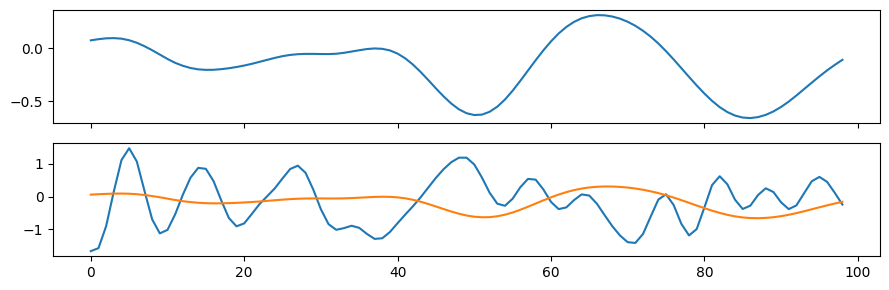

In [ ]:
dls.show_batch(max_n=1)

## Model

In [ ]:
#| export
class Diag_RNN(nn.Module):
    
    @delegates(RNN, keep=True)
    def __init__(self,input_size,output_size,output_layer=1,hidden_size=100,
                 rnn_layer=1,linear_layer = 1,stateful=False,**kwargs):
        super().__init__()
        self.output_size = output_size
        
        self.rnn = RNN(input_size,hidden_size,rnn_layer,stateful=stateful,ret_full_hidden=False,**kwargs) 
        self.final = SeqLinear(hidden_size,int(output_size*output_layer),hidden_layer=linear_layer-1)

    def forward(self, x,init_state = None):
        out,hidden = self.rnn(x,init_state)
        out = self.final(out)
        out = torch.stack(torch.split(out, split_size_or_sections = self.output_size,dim = -1),0)
        return out,hidden
    
    def output_to_hidden(self, out, idx):
        hidden = list(out[:,None,:,idx])
#         hidden = torch.split(out[:,:,idx],split_size_or_sections=1,dim = 0)
        hidden = [ h.contiguous() for h in hidden]
        return hidden
    
    def _get_hidden(self,bs):
        return self.rnn._get_hidden(bs)

In [ ]:
#| export
class Diag_RNN_raw(nn.Module):
    
    def __init__(self,input_size,output_size,output_layer=1,hidden_size=100,
                 rnn_layer=1,linear_layer = 1,stateful=False):
        super().__init__()
        
        self.rnn = RNN(input_size,output_size,output_layer,stateful=stateful,ret_full_hidden=True) 

    def forward(self, x,init_state = None):
        
        return self.rnn(x,init_state)
    
        
    def output_to_hidden(self, out, idx):
        hidden = list(out[:,None,:,idx])
#         hidden = torch.split(out[:,:,idx],split_size_or_sections=1,dim = 0)
        hidden = [ h.contiguous() for h in hidden]
        return hidden

In [ ]:
#| export
class DiagLSTM(nn.Module):

    @delegates(nn.LSTM, keep=True)
    def __init__(self,input_size,output_size,output_layer=1,hidden_size=100,
                 rnn_layer=1,linear_layer = 1,**kwargs):
        super().__init__()
        store_attr()

        self.rnn = nn.LSTM(input_size,hidden_size,rnn_layer,batch_first=True,**kwargs)
        self.final = SeqLinear(hidden_size,int(output_size*output_layer*2),hidden_layer=linear_layer-1)

    def forward(self, x,init_state = None):
        out,_ = self.rnn(x,init_state)
        out = self.final(out)
        #split tensor in n hidden layers of the prognosis rnn
        out = torch.stack(torch.split(out, split_size_or_sections = self.output_size,dim = -1),0)
        return out

    def output_to_hidden(self, out, idx):
        hidden = out[:,:,idx]
        #split in target rnn layers
        lst_hidden = hidden.split(hidden.shape[0]//self.output_layer)
        #split in tuples for the lstm
        lst_hidden = [tuple([h_split.contiguous() for h_split in h.split(h.shape[0]//2,dim=0)]) for h in lst_hidden]
        return lst_hidden

    def _get_hidden(self,bs):
        return self.rnn._get_hidden(bs)

In [ ]:
#| export
class Diag_TCN(nn.Module):
    
    @delegates(TCN, keep=True)
    def __init__(self,input_size,output_size,output_layer,hl_width,mlp_layers=0,**kwargs):
        super().__init__()
        self.output_size = output_size
        
        if mlp_layers>0: 
            self._model = TCN(input_size,hl_width,hl_width=hl_width,**kwargs)
            self.final = SeqLinear(hl_width,int(output_size*output_layer),hidden_size=hl_width,hidden_layer=mlp_layers)
        else:
            self._model = TCN(input_size,int(output_size*output_layer),hl_width=hl_width,**kwargs)
            self.final = nn.Identity()

    def forward(self, x,init_state = None):
        out = self._model(x)
        out = self.final(out)
        out = torch.stack(torch.split(out, split_size_or_sections = self.output_size,dim = -1),0)
        return out,out
    
    def output_to_hidden(self, out, idx):
        hidden = list(out[:,None,:,idx])
#         hidden = torch.split(out[:,:,idx],split_size_or_sections=1,dim = 0)
        hidden = [ h.contiguous() for h in hidden]
        return hidden

In [ ]:
#| export
class ARProg_Init(nn.Module):
    
    @delegates(RNN, keep=True)
    def __init__(self,n_u,n_y,init_sz,n_x=0,hidden_size=100,
                 rnn_layer=1,diag_model=None,linear_layer = 1,final_layer=0,**kwargs):
        super().__init__()
        store_attr()
        
        rnn_kwargs = dict(hidden_size=hidden_size,num_layers=rnn_layer)
        rnn_kwargs = dict(rnn_kwargs, **kwargs)
        
        if diag_model is None:
            self.rnn_diagnosis = Diag_RNN(n_u+n_x+n_y,output_size=hidden_size,hidden_size=hidden_size,output_layer=rnn_layer,rnn_layer=rnn_layer,linear_layer=linear_layer) 
        else:
            self.rnn_diagnosis = diag_model

        self.rnn_prognosis = AR_Model(
            SimpleRNN(input_size=n_u+n_x+n_y,output_size=n_x+n_y,return_state=True,**rnn_kwargs),
            model_has_state=True,return_state=False,ar=True,out_sz=n_x+n_y
            )

    def forward(self, inp):
        y_x = inp[...,self.n_u:] #measured output and external state
        u = inp[...,:self.n_u] #measured input

        if self.training:
            out_diag,_ = self.rnn_diagnosis(inp)
        else:
            out_diag,_ = self.rnn_diagnosis(inp[:,:self.init_sz])
        h_init = self.rnn_diagnosis.output_to_hidden(out_diag,self.init_sz-1)
        self.rnn_prognosis.y_init = y_x[:,self.init_sz:self.init_sz+1]
        out_prog = self.rnn_prognosis(u[:,self.init_sz:],h_init=h_init,ar=True)
        
        result=torch.cat([torch.zeros(inp.shape[0],self.init_sz,y_x.shape[2],device=inp.device),out_prog],1) 

        return result[...,-self.n_y:]

In [ ]:
model = ARProg_Init(1,1,init_sz=init_sz,rnn_layer=1,hidden_size=50)
lrn = Learner(dls,model,loss_func=SkipNLoss(mse,init_sz))
# lrn.fit(1,lr=3e-3)
lrn.fit_flat_cos(1,3e-3,pct_start=0.2)

epoch,train_loss,valid_loss,time
0,0.051080,0.055129,00:01


## FranSys

In [ ]:
#| export
class FranSys(nn.Module):
    
    @delegates(RNN, keep=True)
    def __init__(self,n_u,n_y,init_sz,n_x=0,hidden_size=100,
                 rnn_layer=1,diag_model=None,linear_layer = 1,init_diag_only=False,final_layer=0,**kwargs):
        super().__init__()
        store_attr('n_u,n_y,n_x,init_sz,init_diag_only')
        
        rnn_kwargs = dict(hidden_size=hidden_size,num_layers=rnn_layer,ret_full_hidden=True)
        rnn_kwargs = dict(rnn_kwargs, **kwargs)
        
        if diag_model is None:
            self.rnn_diagnosis = Diag_RNN(n_u+n_x+n_y,hidden_size,hidden_size=hidden_size,output_layer=rnn_layer,rnn_layer=rnn_layer,linear_layer=linear_layer,**kwargs) 
        else:
            self.rnn_diagnosis = diag_model
        self.rnn_prognosis = RNN(n_u,**rnn_kwargs) 

#        self.final = SeqLinear(int(hidden_size*rnn_layer),n_y,hidden_layer=0)
        self.final = SeqLinear(hidden_size,n_y,hidden_layer=final_layer)

    def forward(self, x,init_state = None):
        x_diag = x[...,:self.n_u+self.n_x+self.n_y]
        x_prog = x[...,:self.n_u]
        
        if self.init_diag_only: x_diag = x_diag[:,:self.init_sz] #limit diagnosis length to init size
        
        if self.training:
            #in training, estimate the full sequence with the diagnosis module
            if init_state is None:
                #execution with no initial state
                out_diag,_ = self.rnn_diagnosis(x_diag)
                h_init = self.rnn_diagnosis.output_to_hidden(out_diag,self.init_sz-1)
                
                #ToDo: only execute this if callback is used
                new_hidden = self.rnn_diagnosis.output_to_hidden(out_diag,-1)
                
                out_prog,_ = self.rnn_prognosis(x_prog[:,self.init_sz:].contiguous(),h_init)  
                out_prog=torch.cat([out_diag[:,:,:self.init_sz],out_prog],2) 
            else:
                #import pdb; pdb.set_trace()
                out_prog,_ = self.rnn_prognosis(x_prog,init_state)
                out_diag,_ = self.rnn_diagnosis(x_diag)
                new_hidden = self.rnn_diagnosis.output_to_hidden(out_diag,-1)
        else:
#             import pdb; pdb.set_trace()
            #in inference, use the diagnosis module only for initial state estimation
            if init_state is None:
                out_init,_ = self.rnn_diagnosis(x_diag[:,:self.init_sz])
                h_init = self.rnn_diagnosis.output_to_hidden(out_init,-1)
                out_prog,new_hidden = self.rnn_prognosis(x_prog[:,self.init_sz:],h_init)  
                out_prog=torch.cat([out_init,out_prog],2) 
            else:         
                out_prog,new_hidden = self.rnn_prognosis(x_prog,init_state)

        #Shared Linear Layer
        result = self.final(out_prog[-1])
        return result

In [ ]:
model = FranSys(1,1,init_sz=init_sz,linear_layer=1,rnn_layer=2,hidden_size=50)
lrn = Learner(dls,model,loss_func=nn.MSELoss())
lrn.fit(1,lr=3e-3)

epoch,train_loss,valid_loss,time
0,0.039811,0.035588,00:02


RNN without linear layer as diagnosis module

In [ ]:
#TCN as Diagnosis Module
diag_tcn = Diag_TCN(2,50,2,hl_depth=6,hl_width=20,mlp_layers=3)
model = FranSys(1,1,init_sz=init_sz,linear_layer=1,rnn_layer=2,hidden_size=50,diag_model=diag_tcn)
lrn = Learner(dls,model,loss_func=nn.MSELoss())
lrn.add_cb(TbpttResetCB())
lrn.fit(1,lr=3e-3)

epoch,train_loss,valid_loss,time
0,0.040413,0.033020,00:01


In [ ]:
diag_rnn = Diag_RNN_raw(2,50,2,stateful=False)
model = FranSys(1,1,init_sz=init_sz,linear_layer=1,rnn_layer=2,hidden_size=50,diag_model=diag_rnn)
lrn = Learner(dls,model,loss_func=nn.MSELoss())
lrn.add_cb(TbpttResetCB())
lrn.fit(1,lr=3e-3)

epoch,train_loss,valid_loss,time


Fast variant with initsz diagnosis only

In [ ]:
model = FranSys(1,1,init_sz=init_sz,linear_layer=1,rnn_layer=2,hidden_size=50,init_diag_only=True)
lrn = Learner(dls,model,loss_func=nn.MSELoss(),opt_func=ranger)
lrn.add_cb(TbpttResetCB())
lrn.fit(1,lr=3e-3)

epoch,train_loss,valid_loss,time
0,0.059423,0.057918,00:02


## Callbacks

In [ ]:
#| export
from fastai.callback.hook import *
class FranSysCallback(HookCallback):
    "`Callback` that regularizes the output of the FranSys model."
    def __init__(self,modules, p_state_sync=1e7,#scalingfactor for regularization of hidden state deviation between diag and prog module
                                p_diag_loss=0.0,#scalingfactor of loss calculation of diag hidden state to final layer
                                p_osp_sync=0,#scalingfactor for regularization of hidden state deviation between one step prediction and diag hidden states
                                p_osp_loss=0,#scalingfactor for loss calculation of one step prediction of prog module
                                p_tar_loss=0,#scalingfactor for time activation regularization of combined hiddenstate of diag and prog with target sequence length
                                sync_type='mse',
                                targ_loss_func=mae,
                                osp_n_skip=None,#number of elements to skip before osp is applied, defaults to model.init_sz
                                FranSys_model = None,detach=False, **kwargs):
        super().__init__(modules=modules,detach=detach,**kwargs)
        store_attr('p_state_sync,p_diag_loss,p_osp_sync,p_osp_loss,p_tar_loss,sync_type,targ_loss_func,osp_n_skip,FranSys_model')
        self.clear()
        
    def clear(self):
        self._out_diag = None
        self._out_prog = None
        
    def hook(self, m, i, o): 
        '''add output of diagnosis and prognosis modules to a list for regularization in after_loss'''
        if 'Diag' in type(m).__name__:
            self._out_diag = o[0]
        else:
            self._out_prog = o[0]

    def before_batch(self):
        self.clear()

    def after_loss(self):
        if not self.training: return
        if self._out_diag is None or self._out_prog is None: return

        # redefine variables for convenience
        diag = self._out_diag
        prog = self._out_prog
        self.clear()
        model = self.learn.model if self.FranSys_model is None else self.FranSys_model
        win_reg = self.osp_n_skip if self.osp_n_skip is not None else model.init_sz
        
        diag_trunc = diag
        if diag.shape[2] > prog.shape[2]: diag_trunc = diag_trunc[:,:,-prog.shape[2]:]

        #sync diag prog hidden states loss
        if self.p_state_sync > 0:
            #check if diag length has to be reduced to prog length
        
            if self.sync_type == 'mse': 
                hidden_loss = ((prog-diag_trunc)/
                                (diag_trunc.norm())).pow(2).mean()  
            elif self.sync_type == 'mae':
                hidden_loss = ((prog-diag_trunc)/
                                (diag_trunc.norm())).abs().mean()
            elif self.sync_type == 'mspe':
                hidden_loss = ((diag_trunc-prog)/torch.linalg.norm(diag_trunc,dim=(0,1),keepdim=True)).pow(2).mean()
            elif self.sync_type == 'mape':
                hidden_loss = ((diag_trunc-prog)/torch.linalg.norm(diag_trunc,dim=(0,1),keepdim=True)).abs().mean() 
            elif self.sync_type == 'cos':
                hidden_loss = cos_sim_loss(diag_trunc,prog)
            elif self.sync_type == 'cos_pow':
                hidden_loss = cos_sim_loss_pow(diag_trunc,prog)

            self.learn.loss_grad += self.p_state_sync * hidden_loss  
            self.learn.loss += self.p_state_sync * hidden_loss  

        #self.diag loss
        if self.p_diag_loss > 0:
            y_diag = model.final(diag_trunc[-1])
            hidden_loss = self.targ_loss_func(y_diag,self.yb[0][:,-y_diag.shape[1]:])
            self.learn.loss_grad += self.p_diag_loss*hidden_loss
            self.learn.loss += self.p_diag_loss * hidden_loss  
        
        
        #osp loss - one step prediction on every element of the sequence
        if self.p_osp_loss > 0 or self.p_osp_sync > 0:
            inp = self.xb[0][:,win_reg:]
            bs,n,_ = inp.shape
            #transform to a single batch of prediction length 1
            # import pdb;pdb.set_trace()
            inp = torch.flatten(inp[:,:,:model.n_u],start_dim=0,end_dim=1)[:,None,:]
            h_init = torch.flatten(diag[:,:,win_reg-1:-1], start_dim=1, end_dim=2)[:,None]

            out,_ = model.rnn_prognosis(inp,h_init)
            #undo transform of hiddenstates to original sequence length
            h_out = out[:,:,0] # the hidden state vector, 0 is the index of the single time step taken
            out = out[-1].unflatten(0,(bs,n))[:,:,0]# the single step batch transformed back to the batch of sequences

            #osp hidden sync loss - deviation between diagnosis hidden state and one step prediction hidden state
            h_out_targ = torch.flatten(diag[:,:,win_reg:], start_dim=1, end_dim=2)
            hidden_loss = ((h_out_targ-h_out)/(h_out.norm()+h_out_targ.norm())).pow(2).mean()
            # import pdb;pdb.set_trace()
            self.learn.loss_grad += self.p_osp_sync * hidden_loss  
            self.learn.loss += self.p_osp_sync * hidden_loss 

            #osp target loss - one step prediction error on every timestep
            y_osp = model.final(out)
            hidden_loss = self.targ_loss_func(y_osp,self.yb[0][:,-y_osp.shape[1]:])
            # import pdb;pdb.set_trace()
            self.learn.loss_grad += self.p_osp_loss * hidden_loss  
            self.learn.loss += self.p_osp_loss * hidden_loss  
        
        # tar hidden loss
        if self.p_tar_loss > 0:
            h = torch.cat([diag[:,:,:self.init_sz],prog],2)
            h_diff = (h[:,:,1:] - h[:,:,:-1])
            hidden_loss = h_diff.pow(2).mean()

            # import pdb;pdb.set_trace()
            self.learn.loss_grad += self.p_tar_loss * hidden_loss  
            self.learn.loss += self.p_tar_loss * hidden_loss  

In [ ]:
model = FranSys(1,1,init_sz=init_sz,linear_layer=1,rnn_layer=2,hidden_size=50)
cb = FranSysCallback([model.rnn_diagnosis,model.rnn_prognosis],
                        p_state_sync=1e-1, 
                        p_diag_loss=0.0,
                        p_osp_sync=0,
                        p_osp_loss=0.1,
                        sync_type='cos_pow')
lrn = Learner(dls,model,loss_func=nn.MSELoss(),cbs=cb,opt_func=ranger)
lrn.fit(1,lr=3e-3)

epoch,train_loss,valid_loss,time
0,0.154443,0.057042,00:03


In [ ]:
#| export
class FranSysCallback_variable_init(Callback):
    "`Callback` reports progress after every epoch to the ray tune logger"
    
    def __init__(self,init_sz_min,init_sz_max,**kwargs):
        super().__init__(**kwargs)
        self.init_sz_valid = None
        self.init_sz_min = init_sz_min
        self.init_sz_max = init_sz_max 
    
    def before_batch(self):
        if hasattr(self.learn.model,'init_sz'):
            if self.init_sz_valid is None: self.init_sz_valid = self.learn.model.init_sz
            if self.training:
                self.learn.model.init_sz = np.random.randint(self.init_sz_min,self.init_sz_max+1)
            else:
                self.learn.model.init_sz = self.init_sz_valid

## Learner

In [ ]:
#| export
from tsfast.prediction.core import PredictionCallback

@delegates(FranSys, keep=True)
def FranSysLearner(dls,init_sz,attach_output=False,loss_func=nn.L1Loss(),metrics=fun_rmse,opt_func=Adam,lr=3e-3,cbs=None,**kwargs):
    cbs = [] if cbs is None else list(cbs)
    metrics = list(metrics) if is_iter(metrics) else [metrics]
    
    inp,out = get_inp_out_size(dls)

    if attach_output:
        model = FranSys(inp,out,init_sz,**kwargs)
        pred_callback = PredictionCallback(0)
        pred_callback.init_normalize(dls.one_batch())
        cbs.append(pred_callback)
    else:
        model = FranSys(inp-out,out,init_sz,**kwargs)
  
    skip = partial(SkipNLoss,n_skip=init_sz)
        
    metrics= [skip(f) for f in metrics]
    loss_func = skip(loss_func)
        
    lrn = Learner(dls,model,loss_func=loss_func,metrics=metrics,cbs=cbs,opt_func=opt_func,lr=lr)
    return lrn

In [ ]:
lrn = FranSysLearner(dls,init_sz=50)
lrn.fit(1,lr=3e-3)

epoch,train_loss,valid_loss,fun_rmse,time


RuntimeError: [srcBuf length] > 0 INTERNAL ASSERT FAILED at "/Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/mps/OperationUtils.mm":530, please report a bug to PyTorch. Placeholder tensor is empty!

In [ ]:
dls = create_dls_test(prediction=False)
lrn = FranSysLearner(dls,init_sz=50,attach_output=True)
lrn.fit(1,lr=3e-3)

epoch,train_loss,valid_loss,fun_rmse,time
0,0.178537,0.178313,0.225183,00:01


In [ ]:
#| include: false
import nbdev; nbdev.nbdev_export()